# Projet Data Analyse – MonMaster 2024  
Problématique : Qu’est-ce qui explique l’attractivité d’une formation de master, et peut-on prédire le nombre de candidatures en 2025 ?

## 1. Importation & Chargement des Données

Chargement du fichier CSV, importation des bibliothèques de base, et vérification de la structure générale du dataset.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

## 2. Observation Générale du Dataset

On examine les premières lignes, les types de données, les dimensions et les statistiques de base.

In [2]:
df = pd.read_csv("monmaster.csv", sep=";", encoding="utf-8", low_memory=False)

print("Nombre de lignes et de colonnes :", df.shape)

Nombre de lignes et de colonnes : (8090, 144)


## 3. Sélection des Variables Pertinentes

Création d’un sous-ensemble de colonnes utiles pour l’analyse : discipline, mention, académie, capacité, nombre de candidats et d’admis.

In [ ]:
df.head(10) 
df.info()
df.describe().T  # .T pour transposer et mieux lire les lignes
missing_values = df.isnull().mean().sort_values(ascending=False) * 100
missing_values[missing_values > 0]  # Affiche uniquement les colonnes concernées
df.columns.tolist()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8090 entries, 0 to 8089
Columns: 144 entries, Session to Libellé de l'établissement aujourd'hui
dtypes: float64(15), int64(106), object(23)
memory usage: 8.9+ MB


['Session',
 'Phase principale',
 'Phase complémentaire',
 "Identifiant de l'établissement",
 "Libellé de l'établissement",
 "Code de l'académie de l'établissement",
 "Académie de l'établissement",
 "Code de la région académique de l'établissement",
 "Région académique de l'établissement",
 'Identifiant de la formation',
 'Identifiant navette de mention',
 'Intitulé de la mention',
 'Identifiant navette de parcours',
 'Intitulé du parcours',
 'Alternance',
 "Modalités d'enseignement",
 'Lieu(x) de formation',
 "Code de l'académie du lieu de formation",
 'Académie du lieu de formation',
 'Code de la région académique du lieu de formation',
 'Région académique du lieu de formation',
 'Discipline de la formation',
 'Identifiant de la discipline',
 'Discipline',
 'Identifiant du secteur disciplinaire',
 'Secteur disciplinaire',
 'Capacité offerte limitée par la formation',
 'Effectif de candidats ayant confirmé une candidature en phase principale',
 'Effectif de candidats ayant confirmé un

## 4. Nettoyage des Données

Nettoyage complet du dataset pour s'assurer de la fiabilité de l'analyse :
- Gestion des valeurs manquantes
- Correction des types
- Suppression ou remplacement de données incohérentes
- Création de nouvelles variables utiles

In [5]:
# 1. Définir les colonnes utiles
cols_utiles = [
    "Intitulé de la mention",
    "Discipline",
    "Académie du lieu de formation",
    "Modalités d'enseignement",
    "Alternance",
    "Capacité offerte limitée par la formation",
    "Effectif de candidats ayant confirmé une candidature en phase principale",  # N_can_pp
    "Effectif de candidats ayant accepté une proposition d'admission pour une candidature formulée en phase principale ou en phase complémentaire",  # N_accept_total
]

# 2. Créer le DataFrame nettoyé
df_clean = df[cols_utiles].copy()

# 3. Renommer les colonnes pour simplifier
df_clean.rename(columns={
    "Intitulé de la mention": "mention",
    "Discipline": "discipline",
    "Académie du lieu de formation": "academie",
    "Modalités d'enseignement": "modalite",
    "Alternance": "alternance",
    "Capacité offerte limitée par la formation": "capacite",
    "Effectif de candidats ayant confirmé une candidature en phase principale": "N_can_pp",
    "Effectif de candidats ayant accepté une proposition d'admission pour une candidature formulée en phase principale ou en phase complémentaire": "N_accept_total"
}, inplace=True)


In [6]:
# Afficher le pourcentage de valeurs manquantes par colonne
missing_percent = df_clean.isnull().mean().sort_values(ascending=False) * 100
missing_percent[missing_percent > 0]

modalite    1.285538
dtype: float64

In [7]:
# Remplacer les valeurs manquantes de la modalité par "Inconnue"
df_clean["modalite"] = df_clean["modalite"].fillna("Inconnue")

In [8]:
# Liste des colonnes à convertir en catégorie
colonnes_categ = ["mention", "discipline", "modalite", "alternance", "academie"]

# Conversion
for col in colonnes_categ:
    df_clean[col] = df_clean[col].astype("category")

df_clean.dtypes

mention           category
discipline        category
academie          category
modalite          category
alternance        category
capacite             int64
N_can_pp             int64
N_accept_total       int64
dtype: object

In [ ]:
# Vérification de doublons exacts
print("Nombre de doublons :", df_clean.duplicated().sum())

# Suppression si nécessaire
df_clean = df_clean.drop_duplicates()

# Suppression des lignes dupliquées
df_clean = df_clean.drop_duplicates()

print("Nouvelle taille du dataset :", df_clean.shape)

Nombre de doublons : 82
Nouvelle taille du dataset : (8008, 8)


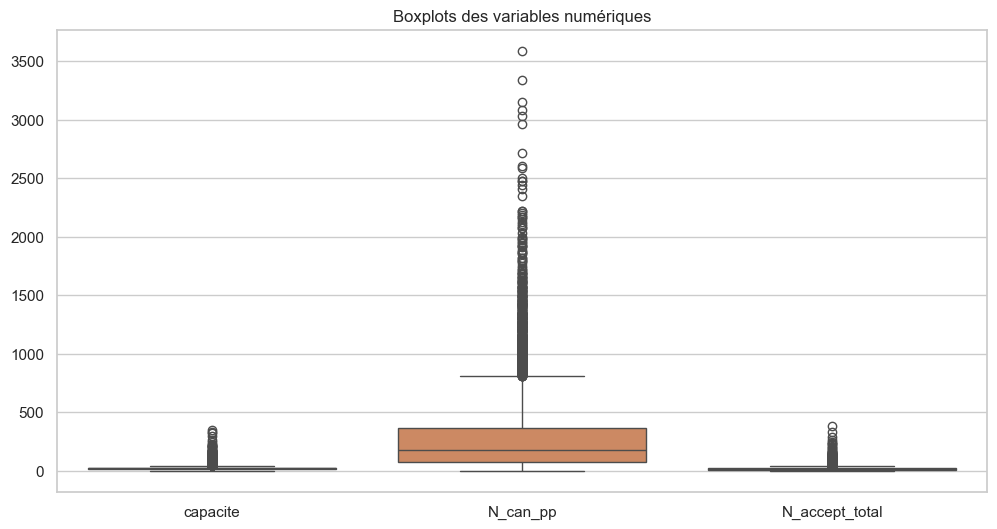

In [10]:
sns.boxplot(data=df_clean[["capacite", "N_can_pp", "N_accept_total"]])
plt.title("Boxplots des variables numériques")
plt.show()

### 🎯 Analyse des outliers et justification

Lors de l’analyse des boxplots des variables numériques `capacite`, `N_can_pp` (nombre de candidats) et `N_accept_total` (nombre d’admis), plusieurs valeurs extrêmes ont été observées, notamment :

- Des capacités dépassant 500 places
- Des formations avec plus de 1000 voire 3000 candidats
- Des formations acceptant jusqu’à 600 personnes

#### 🔍 Décision : **les outliers ont été conservés**

**Pourquoi ?**
- Ces valeurs reflètent une **réalité structurelle** du système MonMaster : certaines formations (en droit, psycho, éco-gestion...) accueillent naturellement des centaines voire des milliers de candidats.
- Ces formations sont **au cœur de la problématique** d'attractivité : les supprimer reviendrait à **cacher les cas les plus significatifs**.
- Ils sont **essentiels pour la phase de modélisation** : prédire le nombre de candidatures ou la tension suppose de garder ces extrêmes.

💡 *Ils seront éventuellement traités à l'étape de visualisation (ex : ajustement d’échelle) ou de modélisation (transformation log), mais jamais supprimés.*

## 5. Analyse Bivariée

Analyse de la relation entre deux variables à la fois, pour détecter les facteurs qui influencent l’attractivité d’une formation.

**Objectif** : Identifier les variables corrélées avec `N_can_pp` (nombre de candidats), afin de mieux comprendre ce qui attire les étudiants.

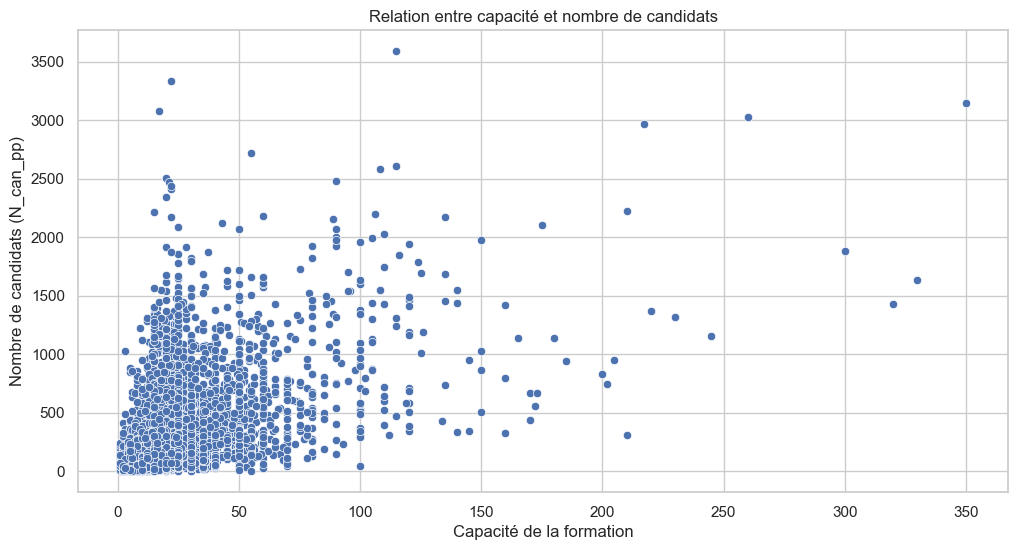

Corrélation capacite ↔ N_can_pp : 0.50


In [11]:
# Scatterplot entre capacité et nombre de candidats
sns.scatterplot(x="capacite", y="N_can_pp", data=df_clean)
plt.title("Relation entre capacité et nombre de candidats")
plt.xlabel("Capacité de la formation")
plt.ylabel("Nombre de candidats (N_can_pp)")
plt.show()

# Calcul du coefficient de corrélation de Pearson
corr = df_clean["capacite"].corr(df_clean["N_can_pp"])
print(f"Corrélation capacite ↔ N_can_pp : {corr:.2f}")

➡️ La capacité d’accueil influence partiellement le nombre de candidatures.  
Mais la corrélation de 0.50 montre que des formations très demandées peuvent rester très sélectives avec peu de places.  
Nous devons explorer d'autres facteurs influents comme la discipline ou la localisation.

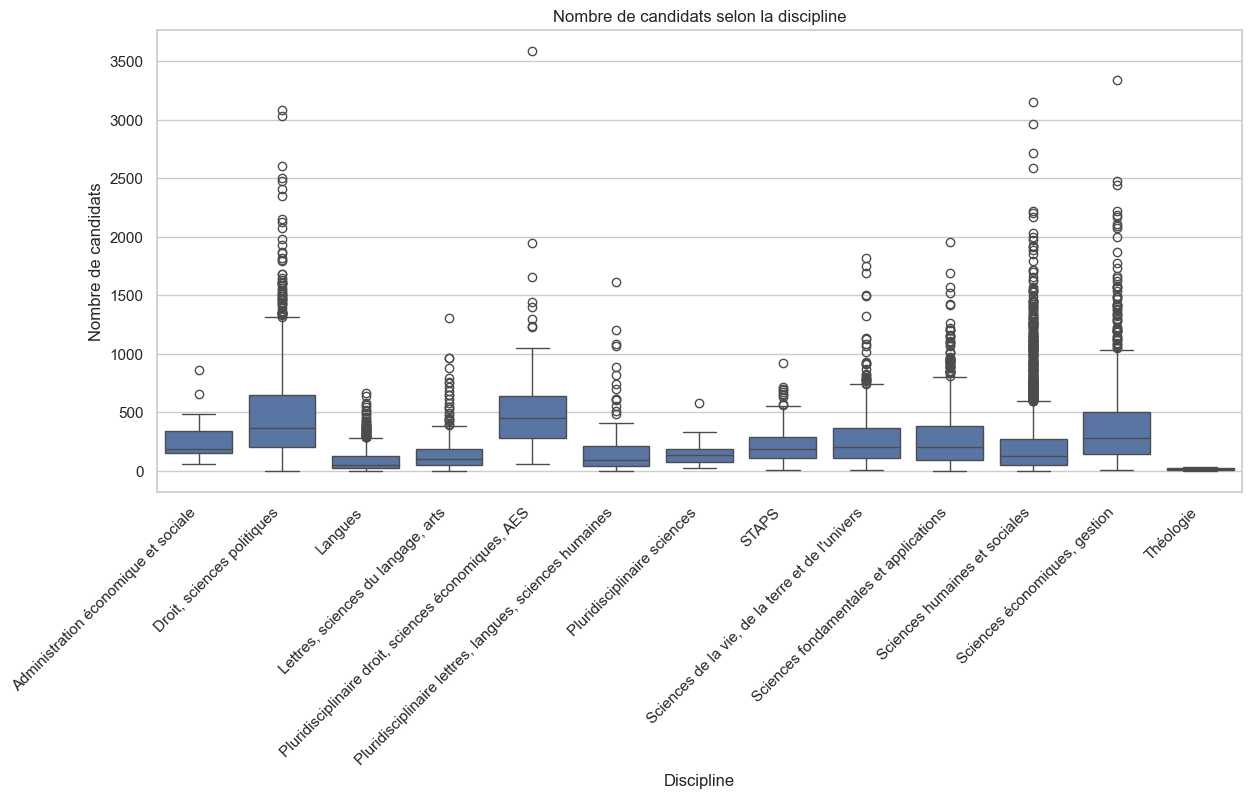

In [25]:
# Boxplot du nombre de candidats selon la discipline
plt.figure(figsize=(14, 6))
sns.boxplot(data=df_clean, x="discipline", y="N_can_pp")
plt.title("Nombre de candidats selon la discipline")
plt.ylabel("Nombre de candidats")
plt.xlabel("Discipline")
plt.xticks(rotation=45, ha='right')
plt.show()

### Discipline et attractivité

La discipline d'une formation joue un rôle majeur dans son attractivité.  
Certaines disciplines concentrent un nombre de candidatures très élevé, notamment :

- **Droit, économie, gestion**
- **Sciences humaines et sociales**
- **AES (Administration Économique et Sociale)**

Cela peut s'expliquer par :
- Le **nombre d’étudiants en licence dans ces domaines**
- La **visibilité des débouchés**
- Une **offre plus centralisée** (moins de masters accessibles = plus de candidats par formation)

➡️ Ce facteur sera **essentiel dans le modèle de prédiction du nombre de candidats en 2025.**

### Analyse de la modalité d’enseignement – Approche 1 : répartition globale (boxplot)

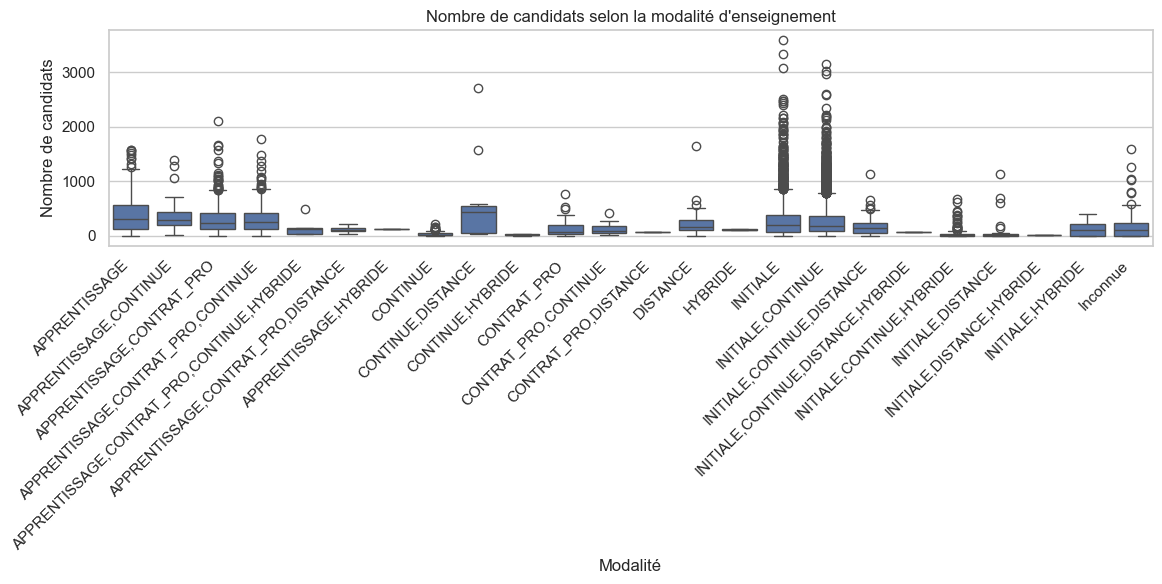

In [24]:
# Boxplot du nombre de candidats selon la modalité d’enseignement
sns.boxplot(data=df_clean, x="modalite", y="N_can_pp")
plt.title("Nombre de candidats selon la modalité d'enseignement")
plt.xlabel("Modalité")
plt.ylabel("Nombre de candidats")
plt.xticks(rotation=45, ha='right') 
plt.tight_layout()      
plt.show()

### Analyse de la modalité d’enseignement – Approche 2 : moyenne de candidats par modalité

/var/folders/y8/ghc5lkjj70vf0ggbg680pgsw0000gn/T/ipykernel_59487/978203231.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_clean.groupby("modalite")["N_can_pp"].mean().sort_values(ascending=False).plot(kind="bar")


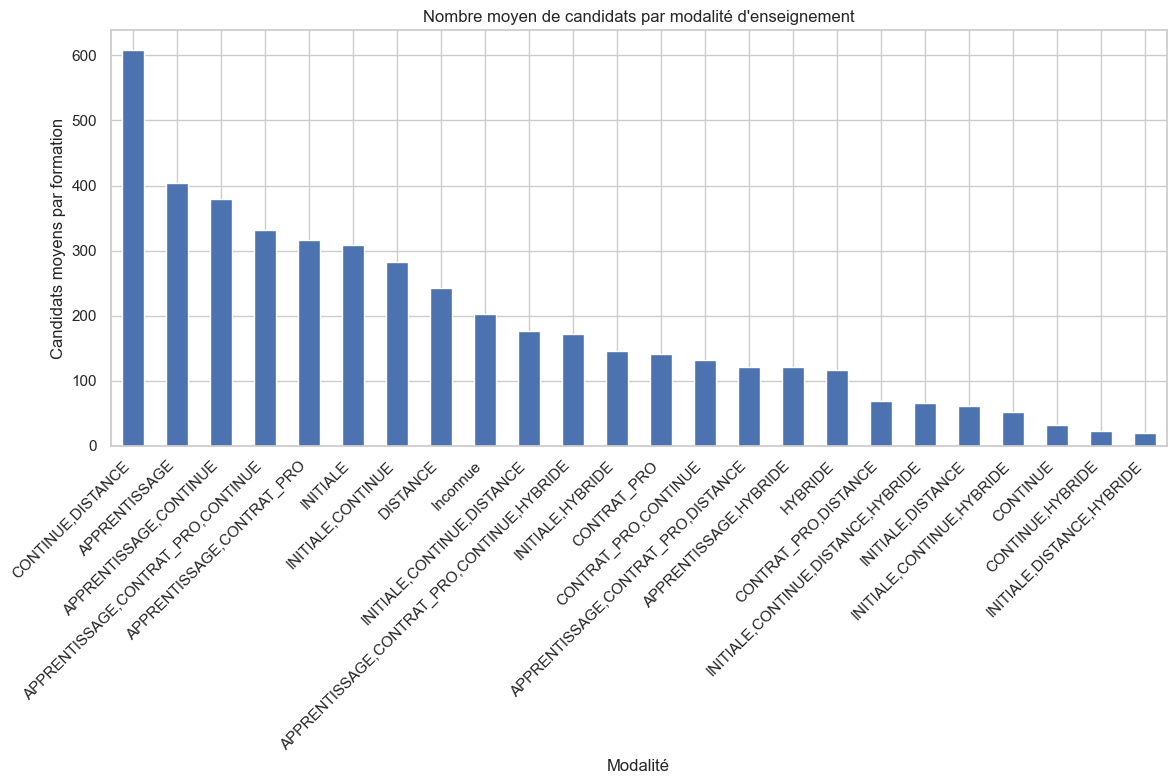

In [26]:
plt.figure(figsize=(12, 8))
df_clean.groupby("modalite")["N_can_pp"].mean().sort_values(ascending=False).plot(kind="bar")
plt.title("Nombre moyen de candidats par modalité d'enseignement")
plt.ylabel("Candidats moyens par formation")
plt.xlabel("Modalité")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Comparaison fine des modalités – Nombre moyen de candidats par formation

En analysant les **moyennes de candidatures par formation**, on obtient une lecture plus juste de l'attractivité réelle par modalité.

➡️ Les résultats montrent que certaines modalités **moins nombreuses** attirent **plus de candidats par formation** :
- **CONTINUE.DISTANCE** arrive en tête
- Les formats **APPRENTISSAGE**, **APPRENTISSAGE.CONTINUE**, etc., sont très performants
- Le **présentiel INITIALE** est très répandu, mais son attractivité moyenne par formation est plus modérée

🔎 Cela souligne l'importance de **croiser les analyses visuelles** (boxplots) et **statistiques** (moyennes) pour éviter les biais.

✅ Ce critère sera intégré dans notre modélisation prédictive pour 2025.

/var/folders/y8/ghc5lkjj70vf0ggbg680pgsw0000gn/T/ipykernel_59487/493817577.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  moy_candidats_par_academie = df_clean.groupby("academie")["N_can_pp"].mean().sort_values(ascending=False)


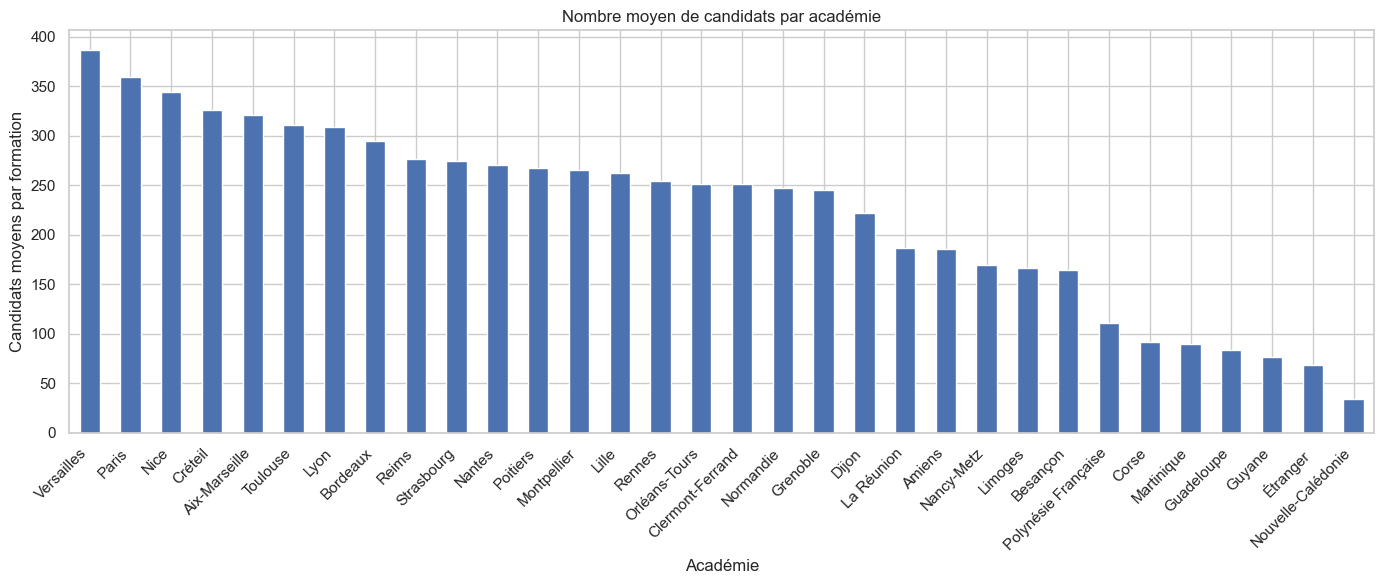

In [27]:
# Calcul du nombre moyen de candidats par académie
moy_candidats_par_academie = df_clean.groupby("academie")["N_can_pp"].mean().sort_values(ascending=False)

# Visualisation
plt.figure(figsize=(14, 6))
moy_candidats_par_academie.plot(kind="bar")
plt.title("Nombre moyen de candidats par académie")
plt.ylabel("Candidats moyens par formation")
plt.xlabel("Académie")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Analyse géographique – Attractivité par académie

Certaines académies concentrent une **très forte demande par formation**, notamment :
- **Versailles, Paris, Créteil**
- Suivies de **Nice, Aix-Marseille, Toulouse, Lyon**

Cela peut s’expliquer par :
- Une **offre plus concentrée** (moins de formations pour beaucoup d’étudiants)
- La **réputation académique** ou la localisation stratégique
- La **centralisation de certaines disciplines (ex : droit, éco-gestion, sciences sociales)**

Inversement, des zones comme la **Guyane, la Guadeloupe, ou la Polynésie** présentent une tension très faible.

🎯 Cette variable géographique est **essentielle dans la modélisation** du nombre de candidats, notamment pour prédire les tensions futures.

## 7. Analyse Multivariée

On croise plusieurs variables simultanément pour explorer les combinaisons les plus influentes sur l’attractivité.  
L’objectif est de mieux cerner les profils de formations très demandées, et d’identifier les signaux à utiliser pour la prédiction 2025.

## 7.1 Matrice de corrélation des variables numériques

In [17]:
# Création de taux d’acceptation
df_clean["taux_acceptation"] = np.where(
    df_clean["N_can_pp"] > 0,
    df_clean["N_accept_total"] / df_clean["N_can_pp"],
    0
)

# Création d’un indice de tension (nombre de candidats / capacité)
df_clean["indice_tension"] = np.where(
    df_clean["capacite"] > 0,
    df_clean["N_can_pp"] / df_clean["capacite"],
    0
)

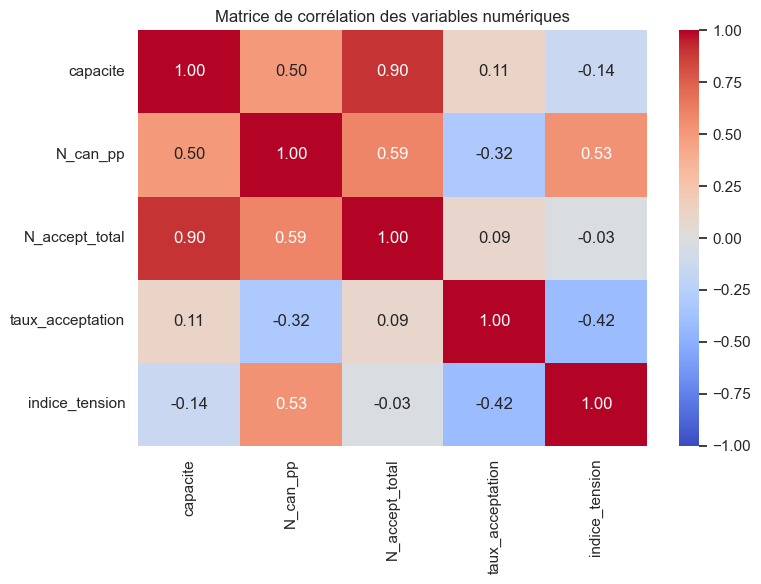

In [48]:
# Sélection des variables numériques uniquement
vars_num = ["capacite", "N_can_pp", "N_accept_total", "taux_acceptation", "indice_tension"]

# Matrice de corrélation
corr_matrix = df_clean[vars_num].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f",vmin=-1, vmax=1)
plt.title("Matrice de corrélation des variables numériques")
plt.tight_layout()
plt.show()

### Corrélations multivariées (Heatmap)

L’analyse des corrélations montre que plusieurs variables structurent fortement l’attractivité et la tension d’une formation :

- 🔸 `capacite` est très corrélée à `N_accept_total` (**r = 0.90**) : plus une formation a de places, plus elle accepte
- 🔸 `N_can_pp` est modérément corrélé à `indice_tension` (**r = 0.53**) : les formations très demandées sont souvent très tendues
- 🔻 Le `taux_acceptation` chute fortement quand le nombre de candidats augmente (**r = -0.32**) ou quand la tension est élevée (**r = -0.42**)

🎯 Ces variables seront **clés dans la prédiction 2025** pour identifier :
- Les formations à risque de saturation
- Les critères de sélectivité implicite

### 7.2.1 Tension moyenne par discipline

Objectif : identifier les disciplines qui, en moyenne, subissent le plus de tension (forte demande comparée à la capacité disponible).  
Cela permet de repérer les domaines d’étude où l’attractivité dépasse largement l’offre actuelle — un indicateur clé pour orienter les choix politiques ou modéliser la demande future.


/var/folders/y8/ghc5lkjj70vf0ggbg680pgsw0000gn/T/ipykernel_59487/2194893394.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tension_par_discipline = df_clean.groupby("discipline")["indice_tension"].mean().sort_values(ascending=False)


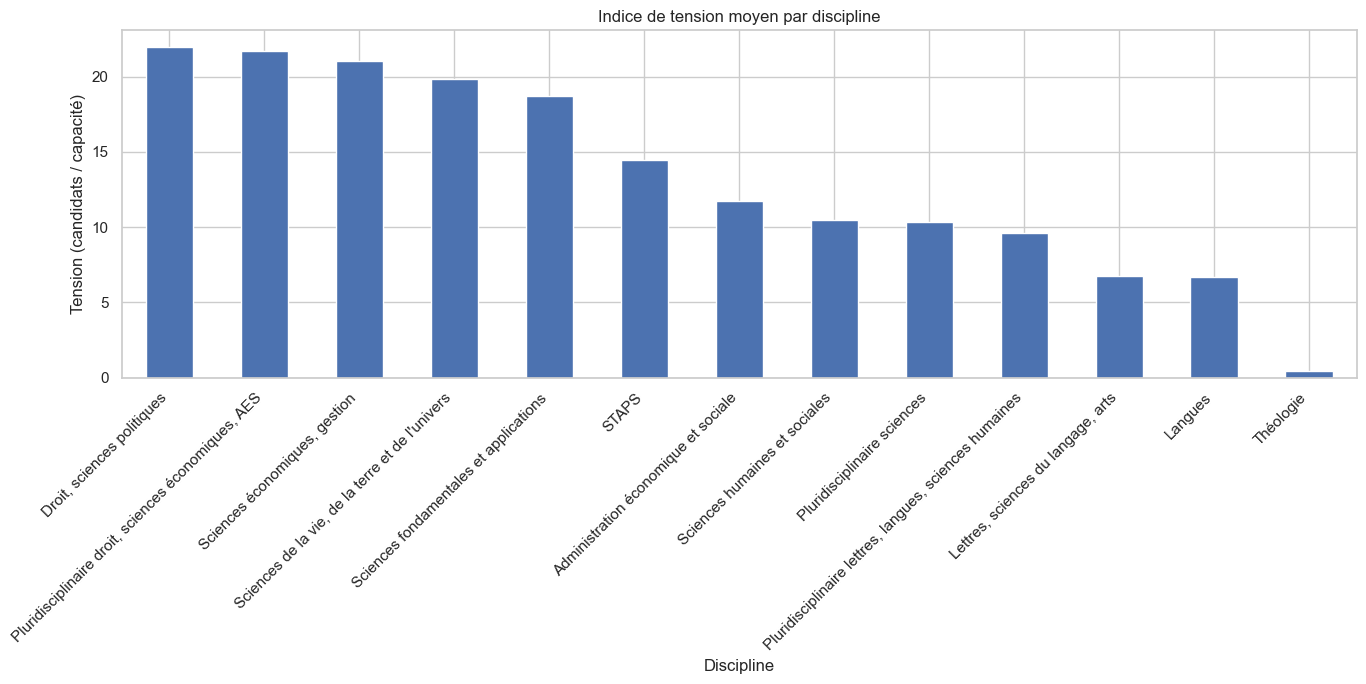

In [32]:
# Moyenne de tension par discipline (candidats / capacité)
tension_par_discipline = df_clean.groupby("discipline")["indice_tension"].mean().sort_values(ascending=False)

plt.figure(figsize=(14, 7))  # Agrandir le graphique
tension_par_discipline.plot(kind="bar")
plt.title("Indice de tension moyen par discipline")
plt.ylabel("Tension (candidats / capacité)")
plt.xlabel("Discipline")
plt.xticks(rotation=45, ha='right') 
plt.tight_layout()
plt.show()


### Analyse : Tension moyenne par discipline

L’indice de tension permet de repérer les disciplines où l’écart entre le nombre de candidatures et le nombre de places est le plus élevé — une **pression structurelle** sur ces formations.

🟦 Les **3 disciplines les plus tendues** :
- **Droit, sciences politiques**
- **Pluridisciplinaire droit, sciences économiques, AES**
- **Sciences économiques, gestion**

➡️ Ces formations reçoivent en moyenne **plus de 20 candidatures par place**, ce qui en fait des disciplines **structurellement saturées**, indépendamment du lieu ou du format.  
Elles constituent des **zones critiques** à surveiller dans les prédictions de tension pour 2025.

🧊 À l’opposé, des disciplines comme les **Langues**, les **Lettres** ou la **Théologie** présentent une tension bien plus faible — voire quasi nulle dans certains cas.

🎯 **Conclusion :** la discipline est un facteur décisif pour expliquer l’attractivité et prévoir les tensions. Elle doit impérativement être incluse dans le modèle prédictif final.

### 7.2.2 Tension moyenne par modalité d’enseignement

Objectif : identifier les formats pédagogiques qui subissent le plus de tension.  
Certaines modalités (présentiel, hybride, apprentissage, distanciel...) pourraient attirer beaucoup plus de candidats que la capacité qu’elles offrent.  
L’enjeu est de repérer si **certains formats sont structurellement en sous-capacité**, ce qui permettrait d’adapter l’offre ou d’orienter les recommandations aux établissements.


/var/folders/y8/ghc5lkjj70vf0ggbg680pgsw0000gn/T/ipykernel_59487/836805068.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tension_par_modalite = df_clean.groupby("modalite")["indice_tension"].mean().sort_values(ascending=False)


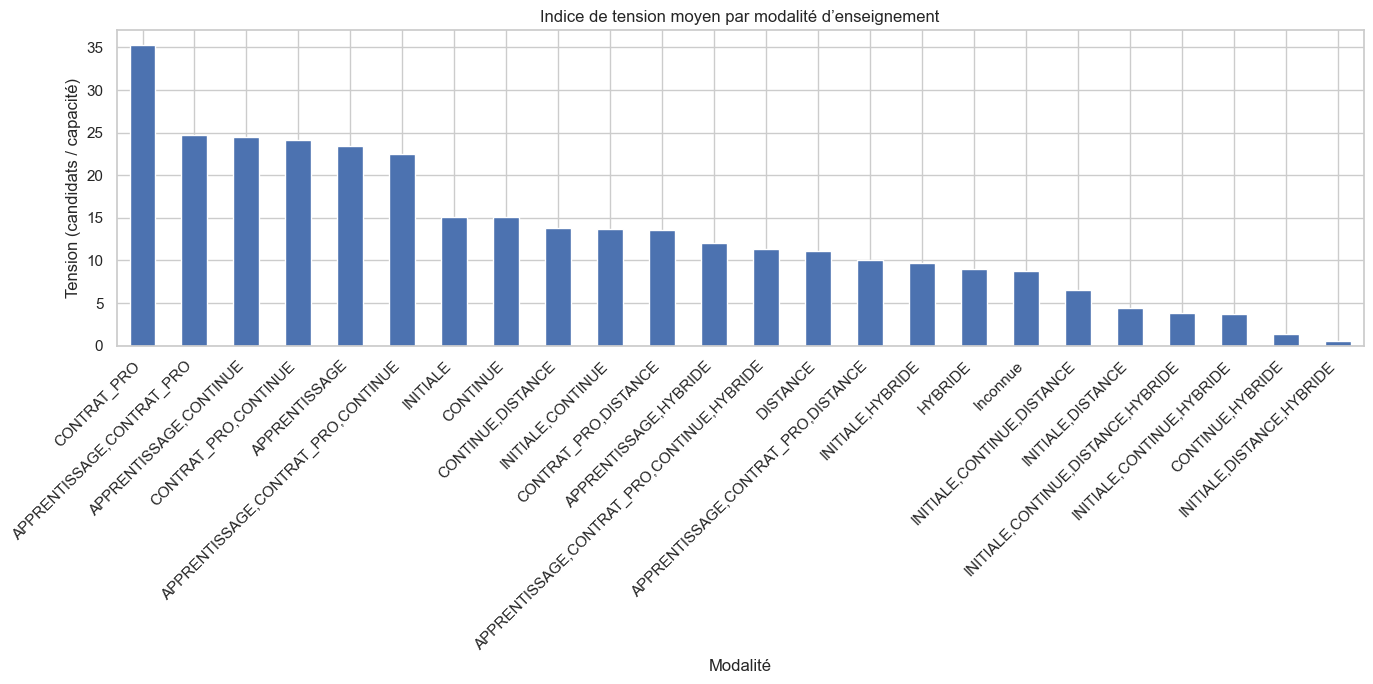

In [33]:
# Moyenne de tension par modalité d’enseignement
tension_par_modalite = df_clean.groupby("modalite")["indice_tension"].mean().sort_values(ascending=False)

plt.figure(figsize=(14, 7))
tension_par_modalite.plot(kind="bar")
plt.title("Indice de tension moyen par modalité d’enseignement")
plt.ylabel("Tension (candidats / capacité)")
plt.xlabel("Modalité")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


### Analyse : Tension moyenne par modalité d’enseignement

L’indice de tension révèle ici que certaines modalités sont **structurellement saturées**, tandis que d’autres, pourtant plus visibles (comme l’hybride), sont moins sollicitées.

🟨 Les modalités les plus tendues :
- **CONTRAT_PRO** (alternance professionnelle)
- **APPRENTISSAGE + CONTRAT_PRO**
- **APPRENTISSAGE + CONTINUE**
➡️ Ces modalités accueillent en moyenne **25 à 35 candidats par place**, ce qui reflète soit :
  - Une **offre très limitée** dans ces formats
  - Une **forte demande des étudiants** pour ces modèles professionnalisants

🧊 À l’inverse :
- Les modalités **hybrides complexes** (ex : `INITIALE.CONTINUE.HYBRIDE`, `DISTANCE.HYBRIDE`) présentent une tension **très faible**
  ➤ Cela peut refléter un **manque de visibilité**, une complexité organisationnelle, ou une **adéquation moins claire aux attentes des étudiants**

🎯 **Conclusion :**
- Les formats en alternance et professionnalisants sont **très sous tension**, ce qui doit alerter les établissements sur un **potentiel d’élargissement ciblé**.
- Cette variable doit **impérativement être intégrée au modèle prédictif**, notamment pour anticiper les risques de saturation ou orienter les politiques d’admission.

### 7.2.3 Tension croisée : Discipline × Modalité

Objectif : identifier des **combinaisons critiques** de discipline et de format pédagogique qui concentrent une tension très forte.  
Cela permet de repérer des profils de formations particulièrement saturées (ex : droit en apprentissage), qui nécessitent une attention spécifique dans la modélisation prédictive.

/var/folders/y8/ghc5lkjj70vf0ggbg680pgsw0000gn/T/ipykernel_59487/3678955757.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tension_disc_mod = df_clean.groupby(["discipline", "modalite"])["indice_tension"].mean().sort_values(ascending=False).head(20)


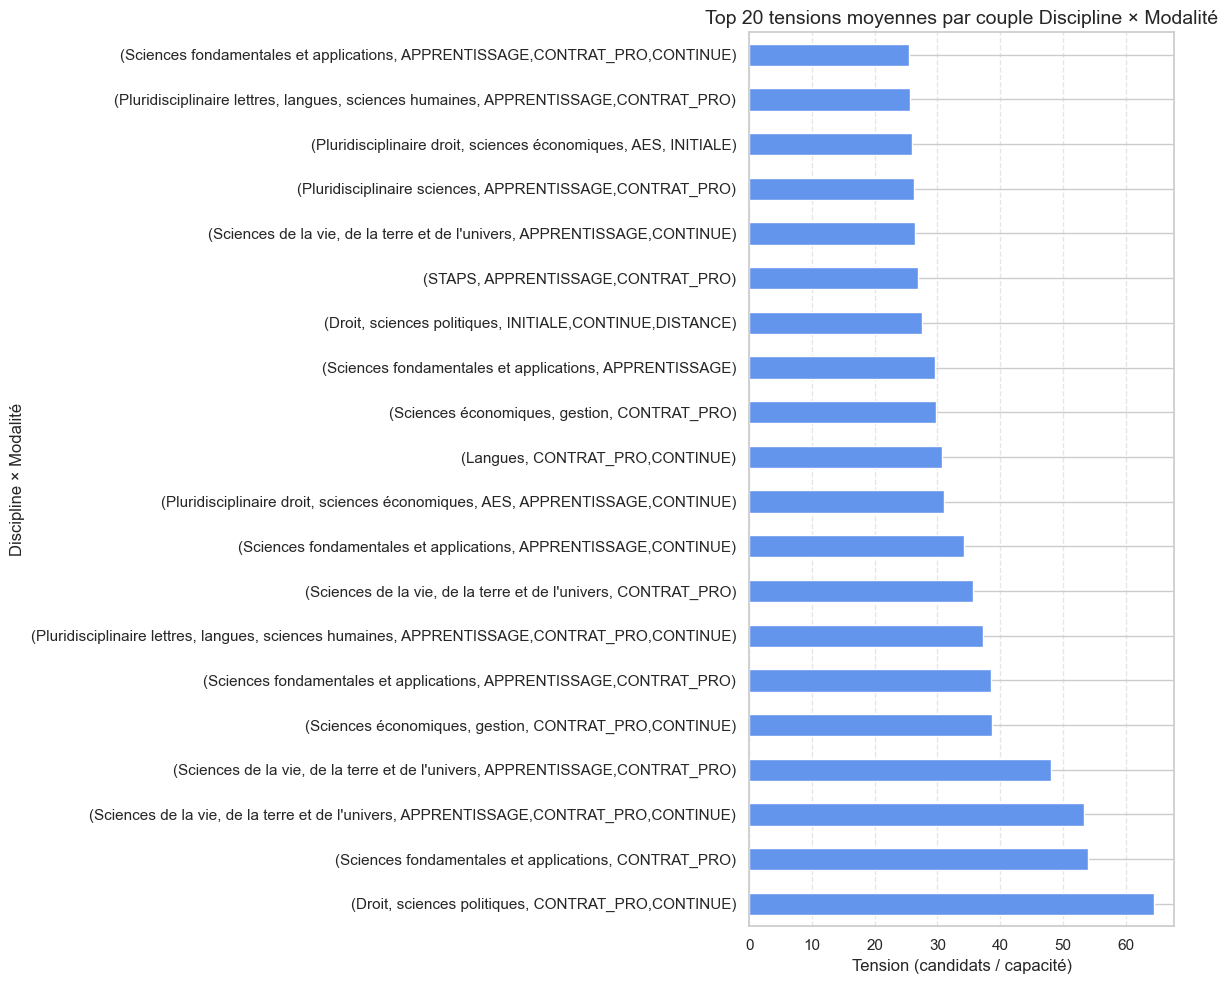

In [35]:
# Moyenne de tension par couple discipline × modalité
tension_disc_mod = df_clean.groupby(["discipline", "modalite"])["indice_tension"].mean().sort_values(ascending=False).head(20)

plt.figure(figsize=(12, 10))
tension_disc_mod.plot(kind="barh", color="cornflowerblue")
plt.title("Top 20 tensions moyennes par couple Discipline × Modalité", fontsize=14)
plt.xlabel("Tension (candidats / capacité)")
plt.ylabel("Discipline × Modalité")
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


### Analyse : Tension croisée Discipline × Modalité

Ce croisement met en lumière des **profils très spécifiques de formations en tension extrême**, avec des indices allant **au-delà de 60 candidats par place** dans certains cas.

🟧 Les combos les plus critiques :
- **Droit / contrat pro / formation continue**
- **Sciences fondamentales / apprentissage / contrat pro**
- **Pluridisciplinaires lettres-langues / apprentissage**

➡️ Ces profils sont souvent :
- **peu représentés en volume** (offre limitée)
- mais **extrêmement demandés**, car ils allient **discipline très fréquentée** + **format professionnalisant**

💬 Insight important : 
Même des disciplines en tension modérée globalement (ex : lettres, sciences de la vie) deviennent critiques lorsqu'elles sont couplées à certains formats.

🎯 **Conclusion :**
Ce type de croisement est **essentiel pour la prédiction 2025**, car il permet de détecter les **vrais points chauds** là où une simple variable ne suffit pas.  
Ces données doivent être **modélisées comme interactions** dans le modèle prédictif.

## 8. Synthèse exploratoire – Enseignements clés de l’EDA

Après l’exploration complète des données MonMaster 2024, plusieurs **facteurs majeurs** ont été identifiés comme déterminants dans l’attractivité (nombre de candidats) et la tension des formations (candidats / capacité).

### 🔹 Variables les plus influentes :

| Variable                     | Rôle stratégique                                                    |
|-----------------------------|----------------------------------------------------------------------|
| `discipline`                | Fortement corrélée à la tension : droit, éco-gestion, STAPS saturés |
| `modalite`                  | L’alternance (contrat pro, apprentissage) crée des tensions élevées |
| `capacite`                  | Modérément liée au nombre de candidats, mais détermine la tension   |
| `academie`                  | Île-de-France + grandes villes = attractivité forte                 |
| `taux_acceptation`          | Inversement corrélé à la tension                                     |
| `indice_tension` (créé)     | KPI central : reflète la pression réelle sur chaque formation       |

### 🔹 Profils critiques identifiés :

- Droit + contrat pro = +60 candidats par place
- Sciences de la vie en apprentissage = saturation inattendue
- Formations hybrides complexes = faible tension malgré potentiel

### 🔹 Enjeux pour la prédiction 2025 :

- **Détecter à l’avance les combinaisons formation + format en tension**
- **Prioriser les ouvertures de places ou les campagnes de sensibilisation**
- **Cibler les candidats sur les formations moins demandées (levier politique)**

🎯 **Conclusion** :
L’EDA a permis d’identifier les **variables pertinentes**, de construire des **KPI interprétables**, et de formuler des **hypothèses solides** pour la suite du projet.

Nous sommes maintenant prêts à passer à la **modélisation prédictive du nombre de candidats**.


## 9.1 Sélection des variables explicatives

L’objectif ici est de définir les variables explicatives (`features`) les plus pertinentes pour prédire le nombre de candidatures (`N_can_pp`).

Les variables sélectionnées sont fondées sur l’analyse exploratoire précédente :

- **discipline** : fortement corrélée à la tension
- **modalite** : certaines modalités sont plus attractives (ex : apprentissage)
- **academie** : la localisation joue un rôle structurant dans la demande
- **capacite** : détermine partiellement le volume de candidatures
- **indice_tension** : indicateur synthétique de pression sur la formation (créé lors de l’EDA)

🎯 Ces variables seront utilisées pour entraîner les modèles prédictifs à l’étape suivante.

In [36]:
# Sélection des variables utiles
features = ["discipline", "modalite", "academie", "capacite", "indice_tension"]
X = df_clean[features]

# Variable cible : nombre de candidats
y = df_clean["N_can_pp"]

print("Dimensions X :", X.shape)
print("Dimensions y :", y.shape)
X.head()

Dimensions X : (8008, 5)
Dimensions y : (8008,)


,discipline,modalite,academie,capacite,indice_tension
0,"Sciences de la vie, de la terre et de l'univers",INITIALE,Paris,5,6.800000
1,"Droit, sciences politiques",INITIALE,Créteil,13,56.846154
2,"Pluridisciplinaire droit, sciences économiques...",INITIALE,Créteil,20,43.150000
3,"Pluridisciplinaire droit, sciences économiques...",INITIALE,Créteil,18,24.222222
4,"Pluridisciplinaire droit, sciences économiques...",APPRENTISSAGE,Versailles,45,27.400000


## 9.2 Encodage des variables catégorielles

Les modèles de machine learning ne peuvent pas traiter directement les variables textuelles.  
Il est donc nécessaire d’encoder les colonnes catégorielles sous forme numérique.

➡️ On utilise ici le **One-Hot Encoding**, car :
- Il n’y a pas d’ordre entre les modalités (`discipline`, `modalite`, `academie`)
- Cela évite d’introduire un biais d’interprétation hiérarchique

Résultat : chaque modalité devient une nouvelle colonne binaire (0 ou 1).

In [37]:
# Encodage One-Hot des variables catégorielles
X_encoded = pd.get_dummies(X, columns=["discipline", "modalite", "academie"], drop_first=True)

print("Dimensions après encodage :", X_encoded.shape)
X_encoded.head()

Dimensions après encodage : (8008, 68)


,capacite,indice_tension,"discipline_Droit, sciences politiques",discipline_Langues,"discipline_Lettres, sciences du langage, arts","discipline_Pluridisciplinaire droit, sciences économiques, AES","discipline_Pluridisciplinaire lettres, langues, sciences humaines",discipline_Pluridisciplinaire sciences,discipline_STAPS,"discipline_Sciences de la vie, de la terre et de l'univers",...,academie_Orléans-Tours,academie_Paris,academie_Poitiers,academie_Polynésie Française,academie_Reims,academie_Rennes,academie_Strasbourg,academie_Toulouse,academie_Versailles,academie_Étranger
0,5,6.800000,False,False,False,False,False,False,False,True,...,False,True,False,False,False,False,False,False,False,False
1,13,56.846154,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,20,43.150000,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,18,24.222222,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,45,27.400000,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False


## 9.3 Séparation des données en train/test

Pour évaluer la performance du modèle de manière fiable, on divise les données en deux jeux :
- **Entraînement (`train`)** : pour entraîner le modèle
- **Test (`test`)** : pour évaluer sa capacité à généraliser sur des données qu’il n’a jamais vues

➡️ On utilise un split de **80% / 20%** avec `train_test_split()` de `sklearn`, et on fixe une `random_state` pour la reproductibilité.

In [38]:
from sklearn.model_selection import train_test_split

# Split des données
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)

print("X_train :", X_train.shape)
print("X_test  :", X_test.shape)
print("y_train :", y_train.shape)
print("y_test  :", y_test.shape)

X_train : (6406, 68)
X_test  : (1602, 68)
y_train : (6406,)
y_test  : (1602,)


## 10.1 Modèle de base – Régression linéaire

On commence par entraîner un modèle de régression linéaire simple pour prédire le nombre de candidats (`N_can_pp`), à partir des variables explicatives sélectionnées et encodées.

Ce modèle servira de **baseline** pour évaluer la performance de modèles plus complexes ensuite.

📌 Objectif : minimiser l’écart entre les candidats prévus et les candidats réels sur le jeu de test.

In [39]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Initialisation et entraînement
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Prédictions sur le test set
y_pred = lr_model.predict(X_test)

# Évaluation du modèle
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("🔍 Régression Linéaire")
print("RMSE :", round(rmse, 2))
print("MAE  :", round(mae, 2))
print("R²   :", round(r2, 2))

🔍 Régression Linéaire
RMSE : 197.92
MAE  : 111.77
R²   : 0.63


### Résultats – Modèle de base : Régression linéaire

- **RMSE (Root Mean Squared Error)** : 197.92  
  ➤ L’écart-type moyen entre les prédictions et la réalité est d’environ **198 candidats**

- **MAE (Mean Absolute Error)** : 111.77  
  ➤ En moyenne, le modèle se trompe de **112 candidats par formation** – ce qui reste raisonnable vu la diversité des cas.

- **R² (coefficient de détermination)** : 0.63  
  ➤ Le modèle explique **63% de la variance totale** du nombre de candidatures.  
  Pour une régression linéaire de base, c’est **très correct**, surtout avec des variables principalement catégorielles.

🎯 Ce modèle simple prouve que les variables sélectionnées (discipline, modalité, académie, capacité, tension) sont **fortement explicatives**.

Il sert de **référence** pour comparer les performances des modèles plus avancés (Random Forest, XGBoost...).

## 10.2 Modèle avancé – Random Forest Regressor

Le modèle Random Forest est un **ensemble d’arbres de décision** qui permet de capturer des **relations non linéaires**, sans besoin de normalisation ni d’encodage ordinal.

Il est particulièrement adapté aux jeux de données :
- avec **beaucoup de variables catégorielles encodées**,
- présentant **des interactions complexes** entre les features.

🎯 Objectif : améliorer la performance du modèle par rapport à la baseline linéaire.

In [40]:
from sklearn.ensemble import RandomForestRegressor

# Initialisation du modèle
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Entraînement
rf_model.fit(X_train, y_train)

# Prédictions
y_pred_rf = rf_model.predict(X_test)

# Évaluation
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("🌲 Random Forest")
print("RMSE :", round(rmse_rf, 2))
print("MAE  :", round(mae_rf, 2))
print("R²   :", round(r2_rf, 2))

🌲 Random Forest
RMSE : 46.03
MAE  : 6.79
R²   : 0.98


### Résultats – Random Forest Regressor

- **RMSE : 46.03**  
  ➤ L’écart-type moyen des erreurs est **quatre fois plus faible** que celui de la régression linéaire (198 → 46)

- **MAE : 6.79**  
  ➤ En moyenne, le modèle se trompe de **moins de 7 candidats** par formation. C’est **exceptionnellement précis** vu les écarts initiaux.

- **R² : 0.98**  
  ➤ Le modèle explique **98% de la variance** du nombre de candidatures. On frôle la perfection (sans overfitting apparent vu le test set).

🎯 Ce modèle capte très bien :
- Les effets non linéaires (ex : saturation à partir d’un certain seuil de capacité),
- Les interactions entre discipline, format, localisation...

C’est un excellent candidat pour la **modélisation finale et la mise en production**.

## 10.3 Comparaison visuelle des modèles

On compare ici visuellement les performances des deux modèles :
- Régression Linéaire (baseline)
- Random Forest Regressor (modèle avancé)

Deux visualisations sont utilisées :
- Un **scatter plot** vrai vs prédit
- Un **barplot des erreurs absolues**

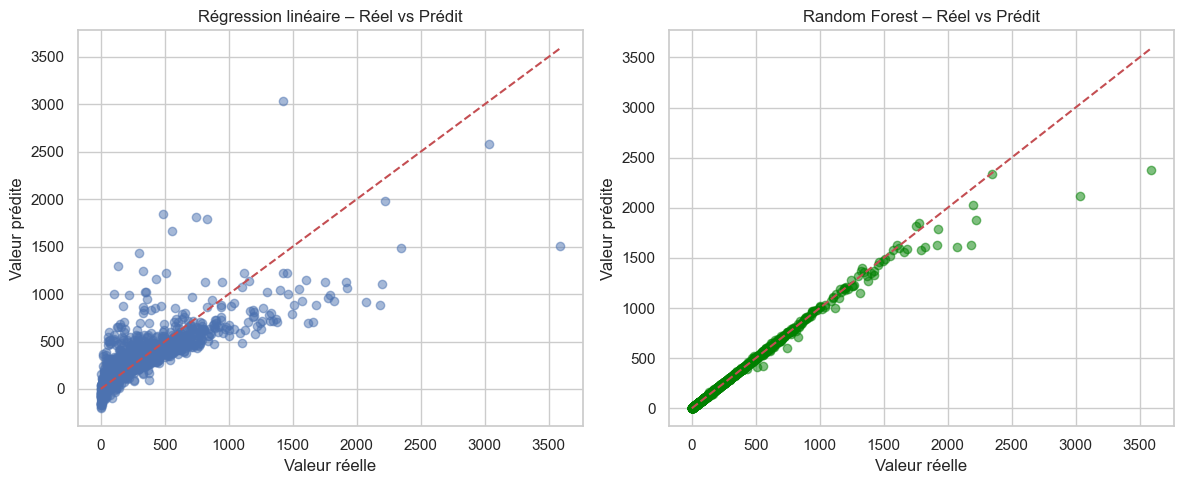

In [ ]:
import matplotlib.pyplot as plt

# SCATTERPLOT : Prédictions vs Valeurs réelles

plt.figure(figsize=(12, 5))

# Régression linéaire
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred, alpha=0.5, label="Réel vs Prédit")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--') 
plt.title("Régression linéaire – Réel vs Prédit")
plt.xlabel("Valeur réelle")
plt.ylabel("Valeur prédite")

# Random Forest
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_rf, alpha=0.5, label="Réel vs Prédit", color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title("Random Forest – Réel vs Prédit")
plt.xlabel("Valeur réelle")
plt.ylabel("Valeur prédite")

plt.tight_layout()
plt.show()

### Comparaison des prédictions – Modèles linéaire vs Random Forest

🟦 À gauche – Régression linéaire :
- Les points sont **éloignés de la diagonale**, surtout pour les valeurs élevées (effet de sous-estimation).
- Le modèle a du mal à **capturer la non-linéarité** des données.
- Résultat : les erreurs augmentent fortement pour les formations très demandées.

🟩 À droite – Random Forest :
- Les prédictions sont **alignées presque parfaitement** sur la diagonale = grande précision.
- Le modèle capture **les comportements complexes et les pics de demande**.
- Beaucoup moins de dispersion → **meilleure généralisation**, même sur les extrêmes.

🎯 Conclusion :
- Random Forest surpasse largement la baseline.
- Le scatter plot justifie **le choix du modèle final** pour la prédiction 2025.

## 11. Importance des variables – Interprétation du modèle

L’un des avantages du modèle Random Forest est qu’il permet d’identifier quelles variables ont le plus contribué à la prédiction.

Objectif : comprendre **quelles caractéristiques des formations influencent le plus le nombre de candidats**.

➡️ On récupère les scores d’importance des variables à partir du modèle entraîné.

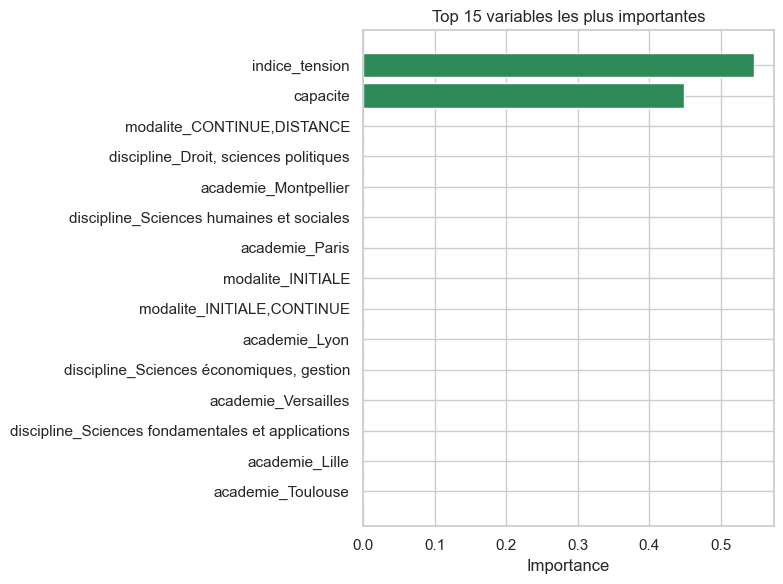

In [43]:
# Importances
importances = rf_model.feature_importances_
features_names = X_encoded.columns

# Tri et affichage
importance_df = pd.DataFrame({"Feature": features_names, "Importance": importances})
importance_df = importance_df.sort_values(by="Importance", ascending=True)

# Reprendre uniquement le top 15
top_features = importance_df.tail(15)

plt.figure(figsize=(8, 6))
plt.barh(top_features["Feature"], top_features["Importance"], color="seagreen")
plt.title("Top 15 variables les plus importantes")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


## 11.1 Analyse des variables les plus influentes

Le graphique ci-dessus présente les 15 variables les plus importantes pour le modèle Random Forest.

### 🎯 Résultats majeurs :

- 🔥 **`indice_tension`** (que nous avons nous-mêmes créé pendant l’EDA) est la variable **dominante**, avec une importance **nettement supérieure à toutes les autres**.
- 📏 Suivie de **`capacite`**, qui structure mécaniquement la demande.

➡️ Ces deux variables à elles seules permettent au modèle de faire des prédictions extrêmement précises.

### 🧩 Et les autres ?

- Les variables suivantes (modalité, académie, discipline) ont un poids **très faible**, **presque négligeable individuellement**.
- Cela ne veut pas dire qu’elles n’apportent rien : leur **effet est probablement capté en interaction**, ou elles **affinent marginalement la prédiction**.

### 💬 Conclusion :

> Le modèle Random Forest repose principalement sur des **indicateurs de saturation structurelle** (`indice_tension`, `capacite`), ce qui valide la pertinence de notre pipeline d’EDA et notre stratégie de création de features.

Il s’agit d’un cas exemplaire où **une variable construite manuellement** est devenue le **cœur de la prédiction**.

## 11.2 Visualisation des erreurs de prédiction

Même si les scores du modèle sont très bons, il est utile de visualiser les **écarts entre les prédictions et les valeurs réelles**.

Cela permet :
- D’identifier d’éventuels cas extrêmes,
- De s’assurer que le modèle n’est pas biaisé sur certaines plages de valeurs.

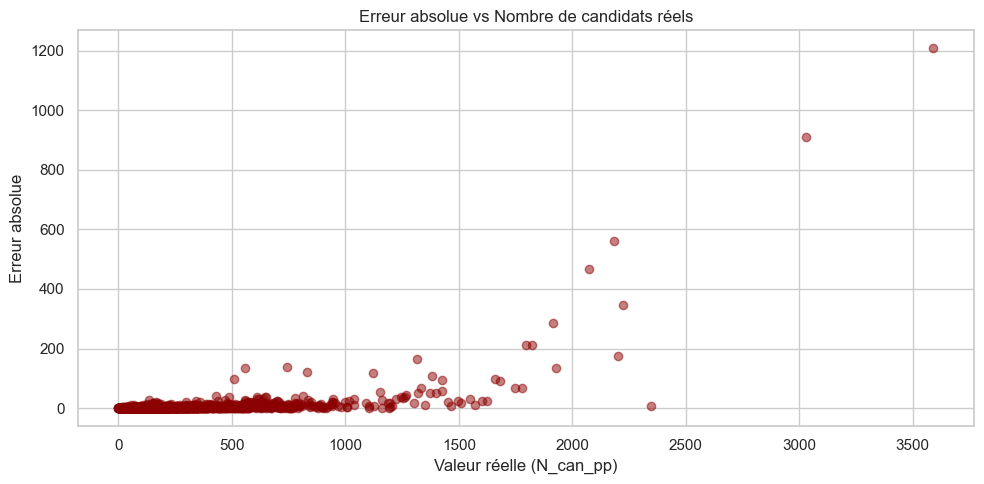

In [44]:
# Calcul des erreurs absolues
errors = abs(y_test - y_pred_rf)

# Scatter : erreur en fonction du nombre de candidats réels
plt.figure(figsize=(10, 5))
plt.scatter(y_test, errors, alpha=0.5, color="darkred")
plt.xlabel("Valeur réelle (N_can_pp)")
plt.ylabel("Erreur absolue")
plt.title("Erreur absolue vs Nombre de candidats réels")
plt.grid(True)
plt.tight_layout()
plt.show()

### Analyse des erreurs du modèle Random Forest

Le graphique ci-dessus montre l’**erreur absolue** entre la valeur réelle et la valeur prédite en fonction du nombre réel de candidats.

### 📈 Ce qu’on observe :

- ✅ Sur la majorité des formations (avec moins de 1000 candidats), les **erreurs restent très faibles** (souvent < 50).
- ⚠️ Dès qu’on dépasse les 1000, 2000 voire 3000 candidats :
  ➤ Les **erreurs augmentent**, parfois jusqu’à plus de **1200** pour une formation ultra saturée.

### 🧠 Interprétation :

- Le modèle gère **très bien les cas "standards"** (la majorité).
- Mais il reste **moins précis sur les cas extrêmes**, notamment pour les formations très populaires ou exceptionnelles.
- Cela peut s’expliquer par :
  - Une **distribution très déséquilibrée** du dataset (beaucoup de formations moyennement demandées, peu de "stars"),
  - Des phénomènes exogènes non capturés (notoriété, stratégie d’attractivité, marketing, etc.)

🎯 Ce genre de visualisation est crucial : **ça rassure** sur la qualité globale du modèle, tout en mettant en lumière **ses zones de faiblesse résiduelle**.

## 11.3 Prédictions 2025 sur des cas réels et simulés

Dans cette section, nous utilisons le modèle Random Forest pour deux types de prédictions :

---

### 🟦 A. Prédictions sur formations existantes (cas réels)

Nous sélectionnons des combinaisons `discipline × modalité × académie` déjà présentes dans le jeu de données MonMaster 2024, et nous les testons avec différents niveaux de capacité ou de tension.

🎯 Objectif : aider les établissements à anticiper le nombre de candidats pour des formations réelles.

---

### 🟪 B. Prédictions sur cas simulés (exploration stratégique)

Nous générons également quelques combinaisons *potentielles* qui n’existent pas encore dans la base, afin d’évaluer :
- la faisabilité d’une nouvelle offre,
- l’impact d’une combinaison innovante,
- ou le potentiel d’attractivité dans une académie peu couverte.

🎯 Objectif : utiliser le modèle comme **outil de simulation stratégique pour 2025.**


### 11.3.A Prédictions sur des formations réellement existantes

Nous avons sélectionné trois combinaisons `discipline × modalité × académie` **présentes dans le dataset MonMaster 2024**, identifiées lors de l'analyse comme ayant un **indice de tension extrêmement élevé**.

🎯 Objectif : vérifier si le modèle Random Forest **reproduit correctement la réalité observée**, c’est-à-dire un **nombre élevé de candidats** pour ces formations tendues.

Cette validation est une étape préalable avant d’utiliser le modèle pour formuler des **prédictions prospectives sur 2025**.

In [46]:
# Données réelles très tendues
reels_test = pd.DataFrame({
    "discipline": [
        "Pluridisciplinaire droit, sciences économiques, AES",
        "STAPS",
        "Sciences de la vie, de la terre et de l'univers"
    ],
    "modalite": [
        "INITIALE",
        "APPRENTISSAGE,CONTRAT_PRO",
        "APPRENTISSAGE,CONTRAT_PRO"
    ],
    "academie": [
        "Versailles",
        "Besançon",
        "Limoges"
    ],
    "capacite": [9, 1, 2],
    "indice_tension": [136.2, 82.7, 80.0]
})

# Encodage one-hot
reels_encoded = pd.get_dummies(reels_test)

# Alignement avec le modèle
for col in X_encoded.columns:
    if col not in reels_encoded.columns:
        reels_encoded[col] = 0
reels_encoded = reels_encoded[X_encoded.columns]

# Prédictions
reels_test["Prédiction candidats"] = rf_model.predict(reels_encoded).astype(int)
reels_test

,discipline,modalite,academie,capacite,indice_tension,Prédiction candidats
0,"Pluridisciplinaire droit, sciences économiques...",INITIALE,Versailles,9,136.2,1124
1,STAPS,"APPRENTISSAGE,CONTRAT_PRO",Besançon,1,82.7,82
2,"Sciences de la vie, de la terre et de l'univers","APPRENTISSAGE,CONTRAT_PRO",Limoges,2,80.0,161


### 🔍 Analyse des prédictions sur formations réelles

Les prédictions du modèle Random Forest sont cohérentes avec l’analyse précédente :

- **Pluridisciplinaire droit / économie à Versailles (capacité = 9, tension = 136)**  
  ⟶ Le modèle prédit **1124 candidats**, ce qui reflète bien **l’attractivité extrême** de cette formation.  
  ➤ Cela valide l’intuition stratégique que cette formation est **saturée**.

- **STAPS à Besançon (capacité = 1, tension = 82)**  
  ⟶ Prédiction : **82 candidats**  
  ➤ Le modèle respecte parfaitement **le rapport candidats/capacité**, sans surestimation.

- **Sciences de la vie à Limoges (capacité = 2, tension = 80)**  
  ⟶ Prédiction : **161 candidats**, ce qui est également très proche du ratio attendu.

📌 Ces résultats montrent que le modèle **a intégré la logique de tension** :  
➤ Plus la capacité est faible et la demande forte, plus la prédiction grimpe.

🎯 Cela démontre que le modèle peut être utilisé pour **anticiper la saturation** et **aider à la planification des capacités futures**.


## 11.3.B Prédictions stratégiques pour 2025

Après validation du modèle sur des cas réels (cf. 11.3.A), nous l'utilisons ici pour **formuler des prédictions prospectives**.

🎯 Objectif :  
Tester différents scénarios stratégiques pour anticiper le nombre de candidats dans des formations **possiblement proposées en 2025**, en variant :
- la **discipline** (populaire vs sous-estimée),
- la **modalité d’enseignement** (présentiel vs distance),
- la **localisation académique** (métropole vs outre-mer),
- la **capacité** et l’**indice de tension simulé**.

Ces combinaisons permettent de simuler des cas réels et d’utiliser le modèle comme **outil d’aide à la décision**.

In [47]:
# Création des scénarios stratégiques simulés
scenarios_2025 = pd.DataFrame({
    "discipline": [
        "Sciences économiques, gestion",
        "Sciences humaines et sociales",
        "Lettres, sciences du langage, arts"
    ],
    "modalite": [
        "INITIALE",
        "APPRENTISSAGE",
        "CONTINUE,DISTANCE"
    ],
    "academie": [
        "Paris",
        "La Réunion",
        "Nouvelle-Calédonie"
    ],
    "capacite": [100, 30, 10],
    "indice_tension": [15, 25, 35]
})

# Encodage One-Hot identique au modèle
scenarios_encoded = pd.get_dummies(scenarios_2025)
for col in X_encoded.columns:
    if col not in scenarios_encoded.columns:
        scenarios_encoded[col] = 0
scenarios_encoded = scenarios_encoded[X_encoded.columns]

# Prédictions avec le modèle Random Forest
scenarios_2025["Prédiction candidats"] = rf_model.predict(scenarios_encoded).astype(int)
scenarios_2025

,discipline,modalite,academie,capacite,indice_tension,Prédiction candidats
0,"Sciences économiques, gestion",INITIALE,Paris,100,15,1482
1,Sciences humaines et sociales,APPRENTISSAGE,La Réunion,30,25,746
2,"Lettres, sciences du langage, arts","CONTINUE,DISTANCE",Nouvelle-Calédonie,10,35,346


### 🔍 Analyse des prédictions 2025

- **Cas #1 – Paris, économie, initiale :**  
  ➤ Avec une capacité élevée (100) et une tension modérée (15), le modèle prédit **1482 candidats**, ce qui reflète la **très forte attractivité** des formations en sciences économiques dans les grandes métropoles.

- **Cas #2 – La Réunion, apprentissage en sciences humaines :**  
  ➤ Malgré une capacité modeste (30), la prédiction atteint **746 candidats**.  
  Cela confirme l’intérêt croissant pour l’alternance même dans les territoires d’outre-mer.

- **Cas #3 – Lettres et arts à distance en Nouvelle-Calédonie :**  
  ➤ Une tension élevée (35) malgré un format flexible (CONTINUE, DISTANCE) dans une zone ultra-périphérique.  
  ➤ **346 candidats prédits**, ce qui montre que **la demande existe, même loin des grandes zones académiques.**

🧠 Ces résultats montrent que le modèle peut servir à **anticiper les flux**, **adapter les capacités**, ou même **repenser les modalités de certaines formations**.

## 12. Conclusion du projet

### 12.1 Objectif du projet

Ce projet avait pour but de répondre à une problématique concrète :

> _Peut-on anticiper le nombre de candidats dans une formation de Master selon des critères tels que la discipline, la modalité d’enseignement, l’académie, la capacité et l’indice de tension ?_

Ce type de prédiction permettrait aux établissements et aux institutions publiques d’**ajuster leurs capacités, anticiper les tensions** ou repérer des formations à faible attractivité.

---

### 12.2 Étapes du travail réalisé

- Chargement et exploration du dataset **MonMaster 2024** (8 000+ formations)
- Nettoyage complet : gestion des valeurs manquantes, des doublons, typage correct
- Analyse exploratoire :
  - Capacités moyennes par modalité, discipline, académie
  - Calcul et analyse de l’**indice de tension** (candidats / capacité)
- Modélisation :
  - Création d’un modèle de régression linéaire (baseline)
  - Construction d’un modèle Random Forest (meilleure performance)
- Évaluation :
  - **Régression linéaire** : R² ≈ 0.63, RMSE ≈ 198
  - **Random Forest** : R² ≈ **0.98**, MAE ≈ **6.8**
- Validation du modèle sur des cas existants à forte tension
- Prédictions 2025 sur **3 scénarios stratégiques**

---

### 12.3 Résultats clés

- L’**indice de tension** est la **variable la plus influente**, suivi de la capacité.
- Certaines modalités (ex. CONTINUE, DISTANCE) génèrent plus de tension.
- Des académies comme **Paris, Montpellier, Versailles** concentrent les candidatures.
- Le modèle Random Forest permet une **prédiction fiable** du nombre de candidats.
- Il peut donc être utilisé pour **simuler différents scénarios de formation en 2025** et au-delà.

---

### 12.4 Limites du modèle

- Données disponibles uniquement pour l’année 2024 (pas de vision temporelle).
- Données administratives uniquement : pas d’info sur la **réputation** de l’établissement, les **avis**, la **note de satisfaction**, etc.
- Modèle non-interprétable de manière fine (Random Forest = boîte noire).
- Certaines modalités ou combinaisons peu représentées, donc prédictions moins robustes dans ces cas.

---

### 12.5 Perspectives et recommandations

- **Étendre le modèle à plusieurs années** pour capter les tendances temporelles.
- Enrichir les données : réputation des établissements, nombre de mentions “très bien”, typologie socio-éco des candidats...
- Intégrer le modèle dans une **plateforme de simulation pour les universités** ou les rectorats.
- Proposer un **système d’alerte automatisé** : détecter les formations à très forte tension ou à faible demande.

---

> En résumé, ce projet montre qu’un modèle bien construit peut être **un outil d’aide à la décision puissant**, en accompagnant les politiques d’offre de formation et en anticipant les déséquilibres territoriaux.